In [ ]:

from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from os import system, listdir
from os.path import join
import glob
import string

import matplotlib.pyplot as plt
from matplotlib import cm
import spacy


# Utilities
def load_text(path):
    chunks = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            chunks.append(line.lower())
    return "".join(chunks)


# Load text
text = load_text("data/text.txt")


# Load spaCy model
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 10_000_000   # must be > len(text)


# Stopwords
stopwords = set(STOPWORDS)

# Basic noise & formatting
stopwords.update([
    "said", "et", "al", "fig", "figure", "number",
    "one", "two", "using", "use", "also", "may", "however",
    "results", "result", "data", "based", "show", "shown",
    "http", "https", "doi", "component", "free",
    "corresponding", "author", "authors",
    "rights", "reserved", "used", "case",
    "wang", "datum", "different", "effect", "effects",
    "wave wave", "requiere", "table", "similar"
])

# Generic filler words
stopwords.update([
    "work", "study", "paper", "section", "introduction", "conclusion", "article",
    "analysis", "discussion", "final", "present", "previous",
    "overall", "main", "general", "important", "significant",
    "basic", "effective", "necessary", "possible", "available",
    "actual", "original", "true", "large", "small", "output"
])

# Methodology boilerplate
stopwords.update([
    "process", "procedure", "framework", "strategy", "workflow",
    "methodology", "technique", "system", "task", "operation",
    "implementation", "application", "approach",
    "design", "development"
])

# Training / ML boilerplate
stopwords.update([
    "training", "validation", "batch", "epoch",
    "learning", "rate", "loss", "cost",
    "weight", "update", "gradient", "descent"
])

# Evaluation & metrics
stopwords.update([
    "evaluation", "metric", "low", "high", "good", "many",
    "error", "residual", "misfit", "robustness", "robust"
])

# Dataset artifacts
stopwords.update([
    "dataset", "synthetic", "simulated",
    "ground", "truth", "observation",
    "measurement", "noise", "noisy",
    "test", "sample", "scenario"
])

# Math / physics generic
stopwords.update([
    "equation", "differential", "partial",
    "matrix", "vector", "calculation",
    "variable", "constant", "term",
    "space", "domain", "grid", "cell"
])

# Publication metadata
stopwords.update([
    "ieee", "journal", "conference",
    "transaction", "issn", "preprint"
])

# Case-study bias
stopwords.update([
    "marmousi", "salt", "borehole", "reservoir", "water"
])

# Verbs, connectors, modeling boilerplate
stopwords.update([
    "apply", "obtain", "propose", "give", "require", "consider", "provide",
    "demonstrate", "indicate", "perform", "calculate", "make", "contain",
    "define", "introduce", "learn", "utilize", "describe", "produce",
    "method", "approach", "technique", "algorithm", "process", "procedure",
    "implementation", "application", "framework", "design", "study",
    "experiment", "simulation", "example", "case",
    "input", "output", "layer", "parameter", "value", "point", "set",
    "train", "training", "epoch", "optimizer", "loss", "objective",
    "model", "modeling", "forward",
    "table", "figure", "image", "plot", "display",
    "will", "moreover", "although", "finally", "often", "usually",
    "high", "low", "large", "small",
    "km", "km km", "vs", "time", "wave", "field", "physical", "medium",
    "property", "function",
    "first", "show", "step", "give"
])

# Single-letter tokens
stopwords.update(string.ascii_lowercase)


# Acronyms
ACRONYMS = {
    "fwi": "FWI",
    "efwi": "EFWI",
    "rtm": "RTM",
    "pinn": "PINN",
    "pinns": "PINNs",
    "cnn": "CNN",
    "dnn": "DNN",
    "rnn": "RNN",
    "gan": "GAN",
    "fno": "FNO",
    "pde": "PDE",
    "ssim": "SSIM",
    "mse": "MSE",
    "bfgs": "BFGS",
    "fga": "FGA"
}


# Text cleaning
def clean_text(text, stopwords, nlp, acronyms=None):
    tokens = []
    acronyms = acronyms or {}

    doc = nlp(text.lower())
    prev = None

    for token in doc:
        if (
            token.is_alpha and
            token.text not in stopwords and
            token.pos_ in {"NOUN", "ADJ"}
        ):
            lemma = token.lemma_

            # skip duplicated consecutive tokens (km km, time time)
            if lemma == prev:
                continue

            if lemma in acronyms:
                tokens.append(acronyms[lemma])
            else:
                tokens.append(lemma)

            prev = lemma

    return " ".join(tokens)


cleaned_text = clean_text(
    text=text,
    stopwords=stopwords,
    nlp=nlp,
    acronyms=ACRONYMS
)


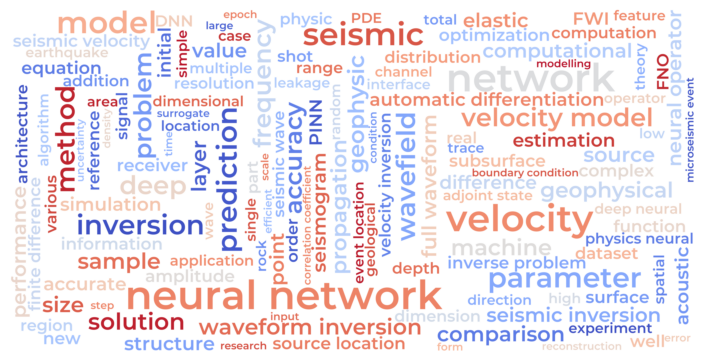

In [331]:
# WordCloud
wc = WordCloud(
    font_path="Montserrat-SemiBold.ttf",
    background_color="white",
    colormap=cm.coolwarm,
    prefer_horizontal=0.7,
    max_words=200,
    width=4100,
    height=2050,
    random_state=1,
    min_font_size=60,
    max_font_size=240
)

wc.generate(cleaned_text)


# Plot
plt.figure(figsize=(7.0, 3.5), constrained_layout=True)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig("figs/wordcloud.pdf", dpi=300)
plt.show()


# Save outputs
with open("data/included_words.txt", "w") as f:
    f.write(",".join(wc.words_.keys()))

with open("data/included_words_with_relevance.txt", "w") as f:
    f.write("word,relevance\n")
    for w, v in sorted(wc.words_.items(), key=lambda x: x[1], reverse=True):
        f.write(f"{w},{v:.6f}\n")